In [1]:
import pandas as pd
import numpy as np
import collections
import copy
import random
import re
import matplotlib.pyplot as plt
from nlp.utils import (
    plot_histogram,
    get_completetext,
    plot_wordcloud,
    print_statistics,
    groups_frequency_sort)
from nlp.text_statistics import (
    count_tokens,
    unique_tokens
)
from utils.read_files import (
    get_items)
from item.item_list import (
    ItemList,
    Item
)
from item.utils import get_tokens_set
import seaborn as sns

sns.set()

# Load price statistics

In [2]:
prices = pd.read_csv('../dados/output/cluster_prices_statistics_year.csv.zip', sep=';')
items = pd.read_csv("../dados/output/items_clusters_train.csv.zip", sep=';')

In [3]:
len(prices[['dsc_unidade_medida', 'cluster']].drop_duplicates())

196630

In [4]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487556 entries, 0 to 487555
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   cluster             487556 non-null  object 
 1   dsc_unidade_medida  487467 non-null  object 
 2   ano                 487556 non-null  int64  
 3   mean                487556 non-null  float64
 4   count               487556 non-null  int64  
 5   max                 487556 non-null  float64
 6   min                 487556 non-null  float64
 7   median              487556 non-null  float64
 8   std                 333272 non-null  float64
 9   var                 333272 non-null  float64
 10  quantile_1          487556 non-null  float64
 11  quantile_3          487556 non-null  float64
dtypes: float64(8), int64(2), object(2)
memory usage: 44.6+ MB


In [31]:
prices['first_token'] = prices['cluster'].str.split('_').str[0]

In [6]:
prices['std'] = prices['std'].fillna(0.0)
prices['var'] = prices['var'].fillna(0.0)
prices['mean'] = prices['mean'].fillna(1.0)

In [7]:
prices = prices.rename({'count': 'n_items'}, axis=1)

In [9]:
prices.head(50)

,cluster,dsc_unidade_medida,ano,mean,n_items,max,min,median,std,var,quantile_1,quantile_3,first_token
0,a100_0,tb,2017,56.000000,2,56.00,56.00,56.000,0.000000,0.000000,56.0000,56.0000,a100
1,a100_0,tubo,2015,60.100000,1,60.10,60.10,60.100,0.000000,0.000000,60.1000,60.1000,a100
2,a100_0,tubo,2017,32.200000,1,32.20,32.20,32.200,0.000000,0.000000,32.2000,32.2000,a100
3,a100_0,tubos,2017,50.550000,1,50.55,50.55,50.550,0.000000,0.000000,50.5500,50.5500,a100
4,a100_0,unidade,2015,52.704615,13,73.60,32.84,60.100,15.247907,232.498677,34.0400,60.1000,a100
5,a100_0,unidade,2016,47.452500,12,55.00,34.04,48.000,7.418752,55.037875,45.8475,55.0000,a100
6,a100_0,unidade,2017,52.747500,12,67.00,33.33,51.000,10.743947,115.432402,50.5500,63.0250,a100
7,a100_0,unidade,2018,40.409643,28,75.75,32.57,32.600,14.558290,211.943804,32.6000,38.2625,a100
8,a100_0,unidades,2015,40.480000,1,40.48,40.48,40.480,0.000000,0.000000,40.4800,40.4800,a100
9,a100_1,litro,2015,77.820000,4,82.04,73.60,77.820,4.872836,23.744533,73.6000,82.0400,a100


In [10]:
group = 'embreagem'

print(len(set(prices[prices.first_token == group]['cluster'])))
print(len((prices[prices.first_token == group].drop_duplicates(['cluster', 'dsc_unidade_medida']))[['cluster', 'dsc_unidade_medida']]))
print(len((prices[(prices.first_token == group) & (prices.n_items >= 20)].drop_duplicates(['cluster', 'dsc_unidade_medida']))[['cluster', 'dsc_unidade_medida']]))

50
223
20


In [11]:
group = 'embreagem'

print(len((prices[(prices.first_token == group)].drop_duplicates(['cluster', 'dsc_unidade_medida', 'ano']))[['cluster', 'dsc_unidade_medida', 'ano']]))
print(len((prices[(prices.first_token == group) & (prices.n_items >= 20)].drop_duplicates(['cluster', 'dsc_unidade_medida', 'ano']))[['cluster', 'dsc_unidade_medida', 'ano']]))

612
39


In [12]:
sum(list((prices[(prices.first_token == 'filtro')].drop_duplicates(['cluster', 'dsc_unidade_medida', 'ano']))['n_items']))

53476

In [13]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4448777 entries, 0 to 4448776
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   item_id             int64  
 1   seq_dim_licitacao   int64  
 2   outlier             int64  
 3   cluster             object 
 4   dsc_unidade_medida  object 
 5   ano                 int64  
 6   description         object 
 7   original            object 
 8   areas               object 
 9   price               float64
dtypes: float64(1), int64(4), object(5)
memory usage: 339.4+ MB


In [14]:
# remove outliers
items = items[items.outlier != 1]

In [15]:
items['first_token'] = items['cluster'].str.split('_').str[0]

In [16]:
items.head(50)

,item_id,seq_dim_licitacao,outlier,cluster,dsc_unidade_medida,ano,description,original,areas,price,first_token
150,4010,716236,0,achocolatar_24,pacote,2017,achocolatar po 400 gr base acucar cacau maltod...,"Achocolatado em pó de 400gr - ACHOCOLATADO, em...",Vazio,4.33,achocolatar
151,4951,716287,0,achocolatar_24,pacote,2018,achocolatar po 400 gr base acucar cacau maltod...,"Achocolatado em pó de 400gr - ACHOCOLATADO, em...",Vazio,3.88,achocolatar
152,31955,722115,0,achocolatar_24,pacote,2017,achocolatar po ii embalagem 400 g composicao a...,Achocolatado em po II - embalagem 400 g. Compo...,Assistência Social | Educação,2.99,achocolatar
153,158513,749927,0,achocolatar_24,unidade,2015,achocolatar po diet 39 menos caloria 35 cacau ...,ACHOCOLATADO EM PO DIET - Achocolatado em pó d...,Vazio,10.35,achocolatar
154,161886,750062,0,achocolatar_24,unidade,2018,achocolatar po diet 39 menos caloria 35 cacau ...,ACHOCOLATADO EM PO DIET - Achocolatado em pó d...,Vazio,10.90,achocolatar
155,291816,768018,0,achocolatar_24,lata 400 gramas,2015,achocolatar po instantaneo vitaminar embalagem...,"Achocolatado, Pó instantâneo, vitaminado. Emba...",Administração | Assistência Social | Educação ...,7.03,achocolatar
156,293172,768076,0,achocolatar_24,lata 400 gramas,2016,achocolatar po instantaneo vitaminar embalagem...,"Achocolatado, Pó instantâneo, vitaminado. Emba...",Administração | Assistência Social | Cultura |...,6.16,achocolatar
157,295138,768152,0,achocolatar_24,lata 400 gramas,2017,achocolatar po instantaneo vitaminar embalagem...,"Achocolatado, Pó instantâneo, vitaminado. Emba...",Administração | Assistência Social | Cultura |...,9.64,achocolatar
158,296621,768211,0,achocolatar_24,lata 400 gramas,2018,achocolatar po instantaneo vitaminar embalagem...,"Achocolatado, Pó instantâneo, vitaminado. Emba...",Administração | Assistência Social | Cultura |...,7.09,achocolatar
159,980999,890352,0,achocolatar_24,pote 400 gramas,2016,achocolatar po instantaneo vitaminar embalagem...,"Achocolatado, em pó instantâneo, vitaminado. E...",Administração | Assistência Social | Cultura |...,4.59,achocolatar


# Termos: combustíveis

- gasolina
- álcool
- querosene
- óleo
- etanol
- diesel

In [307]:
combustiveis = ['gasolina', 'alcool', 'querosene', 'oleo', 'etanol', 'diesel']

# Termos: hospitais e Medicamentos

- álcool
- vitamina
- ácido
- lorazepam
- luva
- mascara
- algodão
- dipirona
- sabonete
- sabao
- pen
- atenolol
- alopurinol
- dea
- estetoscopio
- maca
- hospitalar
- reanimador
- esfigmomanômetro
- oxímetro
- camisola

In [308]:
hospitais_med = ['luva', 'mascara', 'acido', 'sabao', 'sabonete', 'algodao', 'alcool', 'vitamina', \
                 'lorazepam', 'dipirona','pen', 'atenolol', 'alopurinol', 'dea', 'estetoscopio', \
                 'maca', 'hospitalar', 'reanimador', 'esfignomanometro', 'oximetro', 'camisola']

# Termos: peças e serviços automotivos

- bateria
- filtro
- componentes
- capota
- macaco
- pastilha
- espelho
- antena
- carroceria
- lampada
- pneu
- freio
- parabrisa
- parachoque
- roda
- lataria
- calota
- ignicao

In [309]:
pecas_automotivos = ['macaco', 'pneu', 'freio', 'parabrisa', 'parachoque', 'roda', 'lampada', \
                     'bateria', 'pastilha', 'espelho', 'componentes', 'capota', 'antena', \
                     'carroceria', 'lataria', 'calota', 'ignicao', 'filtro', 'amortecedor', \
                     'coxim', 'radiador', 'virabrequim', 'correia', 'embreagem']

# Ano

In [310]:
clusters_years = prices[['dsc_unidade_medida', 'ano', 'first_token', 'cluster']]

In [311]:
clusters_years = clusters_years.drop_duplicates()

In [312]:
clusters_years

,dsc_unidade_medida,ano,first_token,cluster
0,tb,2017,a100,a100_0
1,tubo,2015,a100,a100_0
2,tubo,2017,a100,a100_0
3,tubos,2017,a100,a100_0
4,unidade,2015,a100,a100_0
...,...,...,...,...
487551,unidade,2015,ziper,ziper_3
487552,unidade,2016,ziper,ziper_3
487553,unidade,2017,ziper,ziper_3
487554,unidade,2018,ziper,ziper_3


In [313]:
clusters_years = clusters_years.fillna('.')

## Número de anos

In [314]:
# group by "cluster" and "dsc_unidade_medida"
clusters_years['years'] = clusters_years.groupby(['cluster', 'dsc_unidade_medida'])['cluster'].transform('count')

In [315]:
clusters_years = clusters_years[['first_token', 'cluster', 'dsc_unidade_medida', 'years']]

In [316]:
# drop duplicates
clusters_years = clusters_years.drop_duplicates()

In [317]:
clusters_years.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196630 entries, 0 to 487555
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   first_token         196630 non-null  object
 1   cluster             196630 non-null  object
 2   dsc_unidade_medida  196630 non-null  object
 3   years               196630 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 7.5+ MB


In [318]:
set(clusters_years['years'])

{1, 2, 3, 4}

## Número de itens

In [323]:
# group by "cluster" and "dsc_unidade_medida"
clusters_num_items = prices[['dsc_unidade_medida', 'cluster', 'first_token', 'ano', 'n_items']]

In [324]:
clusters_num_items = clusters_num_items.groupby(['cluster', 'dsc_unidade_medida'], as_index=False)['n_items'].sum()

In [325]:
clusters_num_items.head()

,cluster,dsc_unidade_medida,n_items
0,a100_0,tb,2
1,a100_0,tubo,2
2,a100_0,tubos,1
3,a100_0,unidade,65
4,a100_0,unidades,1


In [326]:
clusters_years = pd.merge(clusters_years, clusters_num_items,  how='left', left_on=['cluster','dsc_unidade_medida'], right_on = ['cluster','dsc_unidade_medida'])

In [327]:
clusters_years = clusters_years.dropna()

In [328]:
clusters_years.head()

,first_token,cluster,dsc_unidade_medida,years,n_items
0,a100,a100_0,tb,1,2.0
1,a100,a100_0,tubo,2,2.0
2,a100,a100_0,tubos,1,1.0
3,a100,a100_0,unidade,4,65.0
4,a100,a100_0,unidades,1,1.0


In [329]:
len(prices[prices.first_token == 'lataria'].drop_duplicates(['cluster', 'dsc_unidade_medida', 'ano']))

0

## Geral

In [330]:
def plot_countplot(dataframe, x):

    sns.set_style("white")

    fig, (axis1) = plt.subplots(figsize=(10,7))

    sns.countplot(x=x, data=dataframe, color='dodgerblue')

    axis1.set_xlabel("Nº de anos", fontsize=20, weight='bold')
    axis1.set_ylabel("Nº de grupos", fontsize=20, weight='bold')
    plt.grid(False)

    total = len(dataframe)
    for p in axis1.patches:
        height = p.get_height()
        axis1.text(p.get_x()+0.01, height+10, '(%d)'%(height), fontsize=15)
        axis1.text(p.get_x()+0.45, height+10, '%.2f%%'%(100*float(height)/total), fontsize=15)

    plt.yticks(fontsize=16)
    plt.xticks(fontsize=16)

    plt.show()
    plt.clf()

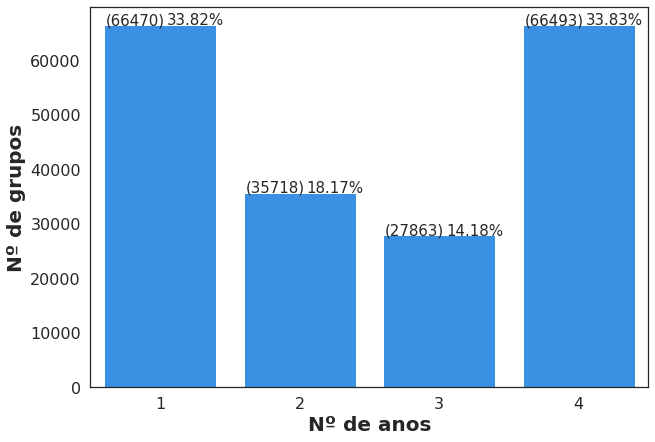

<Figure size 432x288 with 0 Axes>

In [331]:
plot_countplot(clusters_years, 'years')

In [336]:
total_items = sum(list(clusters_years['n_items']))

In [337]:
total_items

3913116.0

In [339]:
sum(list(clusters_years[clusters_years.years == 4]['n_items']))

3360979.0

In [340]:
100*sum(list(clusters_years[clusters_years.years == 4]['n_items']))/total_items

85.8900937258185

## Combustíveis

In [341]:
combustiveis_years = clusters_years[clusters_years['first_token'].isin(combustiveis)]

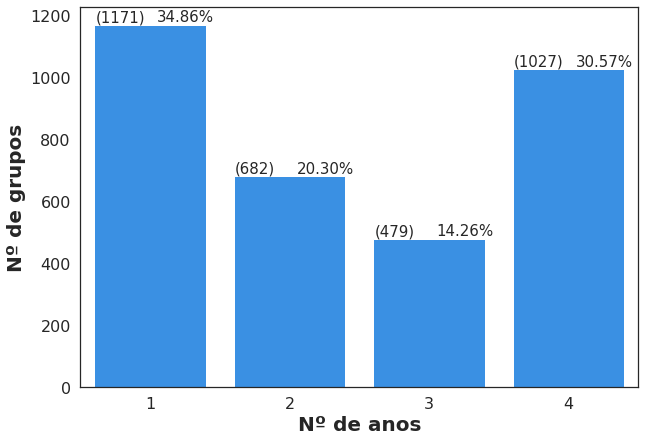

<Figure size 432x288 with 0 Axes>

In [342]:
plot_countplot(combustiveis_years, 'years')

In [343]:
total_items = sum(list(combustiveis_years['n_items']))

In [344]:
total_items

49252.0

In [345]:
sum(list(combustiveis_years[combustiveis_years.years == 4]['n_items']))

41893.0

In [346]:
100*sum(list(combustiveis_years[combustiveis_years.years == 4]['n_items']))/total_items

85.05847478274994

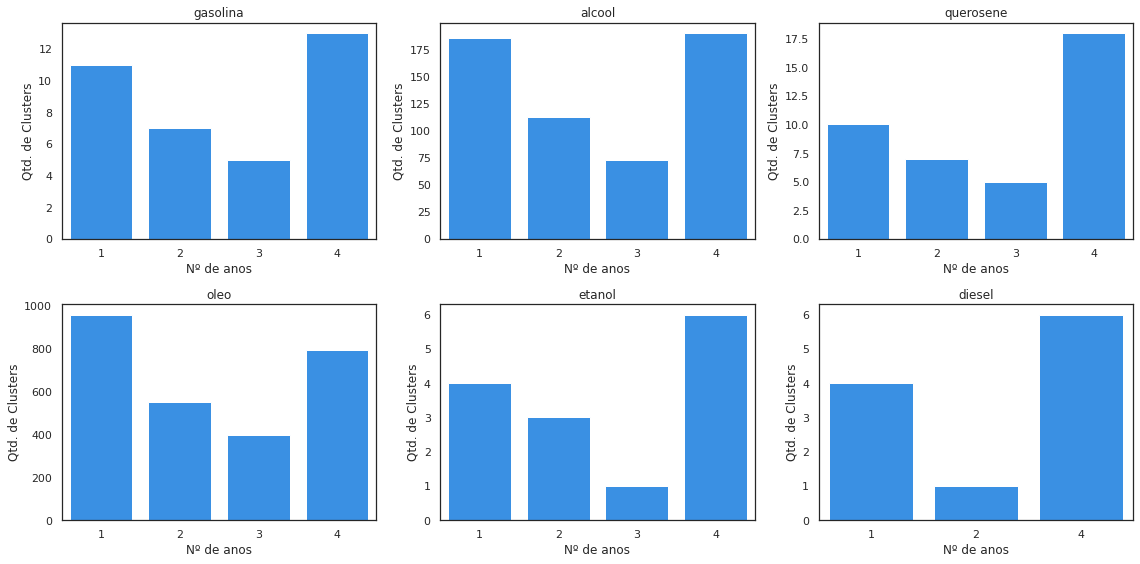

In [347]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, combustiveis):
    items_termo = combustiveis_years[combustiveis_years.first_token == termo]
    qtd_clusters = items_termo.drop_duplicates(['cluster', 'dsc_unidade_medida']).groupby("years").apply(lambda clusters: len(clusters))
    sns.barplot(x=qtd_clusters.index, y=qtd_clusters.values, ax=ax, color='dodgerblue')
    ax.set(xlabel="Nº de anos", ylabel="Qtd. de Clusters", title=termo)
fig.tight_layout()
plt.show()

### Quantidade de grupos por ano

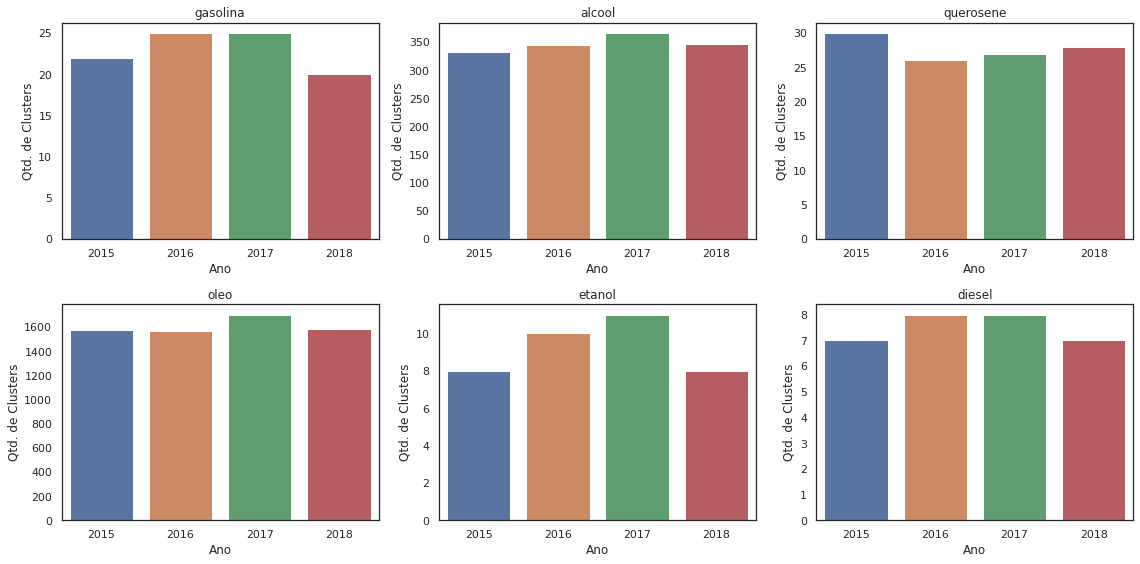

In [45]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, combustiveis):
    items_termo = items[items.first_token == termo]
    qtd_clusters = items_termo.drop_duplicates(['cluster', 'dsc_unidade_medida', 'ano']).groupby("ano").apply(lambda clusters: len(clusters))
    sns.barplot(x=qtd_clusters.index, y=qtd_clusters.values, ax=ax)
    ax.set(xlabel="Ano", ylabel="Qtd. de Clusters", title=termo)
fig.tight_layout()
plt.show()

## Hospitais e medicamentos

In [46]:
hospmedicamento_years = clusters_years[clusters_years['first_token'].isin(hospitais_med)]

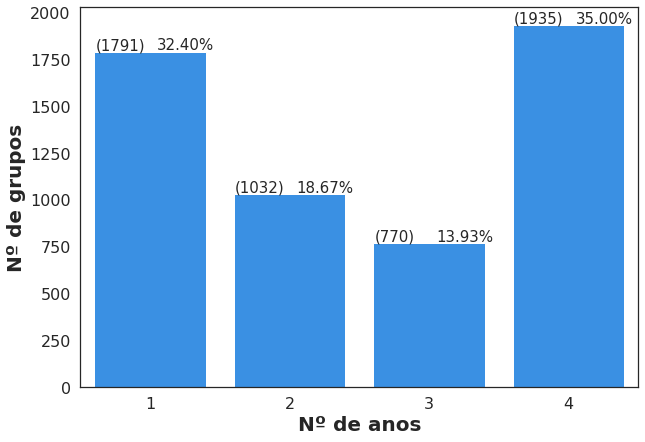

<Figure size 432x288 with 0 Axes>

In [47]:
plot_countplot(hospmedicamento_years, 'years')

In [48]:
total_items = sum(list(hospmedicamento_years['n_items']))

In [49]:
total_items

124600.0

In [50]:
sum(list(hospmedicamento_years[hospmedicamento_years.years == 4]['n_items']))

112933.0

In [51]:
100*sum(list(hospmedicamento_years[hospmedicamento_years.years == 4]['n_items']))/total_items

90.63643659711076

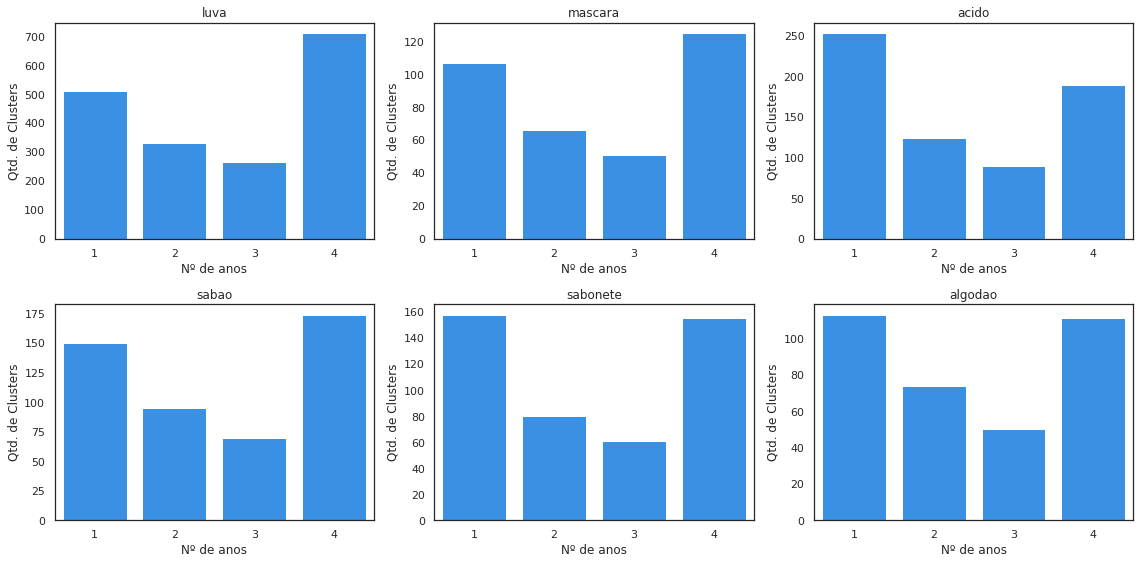

In [52]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, hospitais_med):
    items_termo = hospmedicamento_years[hospmedicamento_years.first_token == termo]
    qtd_clusters = items_termo.drop_duplicates(['cluster', 'dsc_unidade_medida']).groupby("years").apply(lambda clusters: len(clusters))
    sns.barplot(x=qtd_clusters.index, y=qtd_clusters.values, ax=ax, color='dodgerblue')
    ax.set(xlabel="Nº de anos", ylabel="Qtd. de Clusters", title=termo)
fig.tight_layout()
plt.show()

### Quantidade de grupos por ano

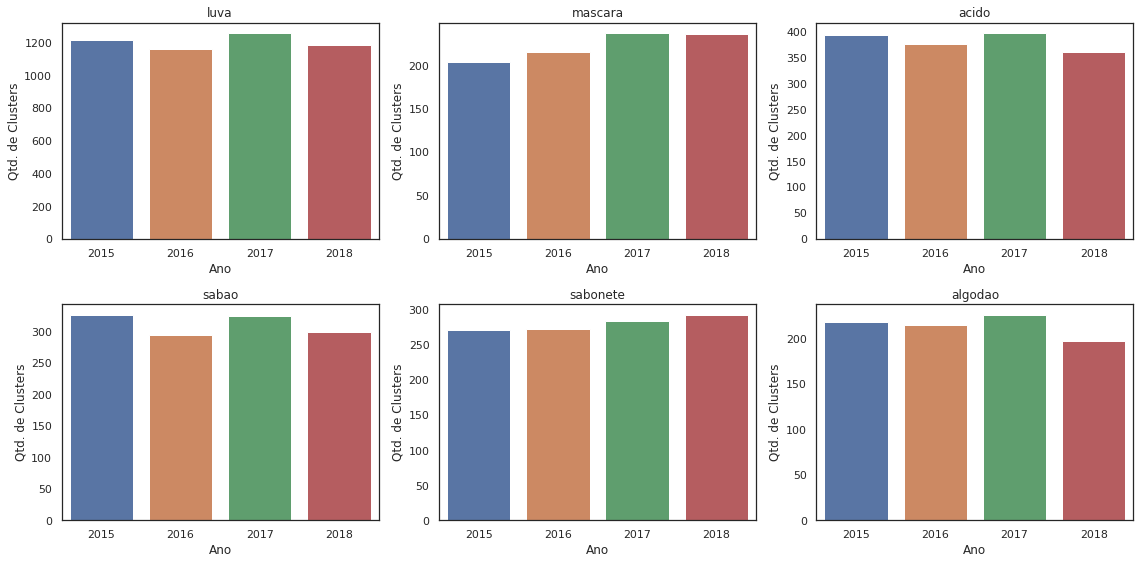

In [53]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, hospitais_med):
    items_termo = items[items.first_token == termo]
    qtd_clusters = items_termo.drop_duplicates(['cluster', 'dsc_unidade_medida', 'ano']).groupby("ano").apply(lambda clusters: len(clusters))
    sns.barplot(x=qtd_clusters.index, y=qtd_clusters.values, ax=ax)
    ax.set(xlabel="Ano", ylabel="Qtd. de Clusters", title=termo)
fig.tight_layout()
plt.show()

## Peças e serviços automotivos

In [348]:
pecas_years = clusters_years[clusters_years['first_token'].isin(pecas_automotivos)]

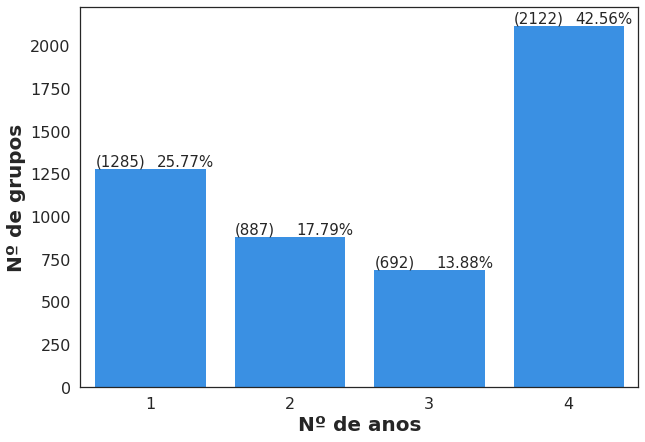

<Figure size 432x288 with 0 Axes>

In [349]:
plot_countplot(pecas_years, 'years')

In [352]:
total_items = sum(list(pecas_years['n_items']))

In [356]:
total_items

190953.0

In [361]:
sum(list(pecas_years[pecas_years.years == 4]['n_items']))

172445.0

In [362]:
100*sum(list(pecas_years[pecas_years.years == 4]['n_items']))/total_items

90.30756259393672

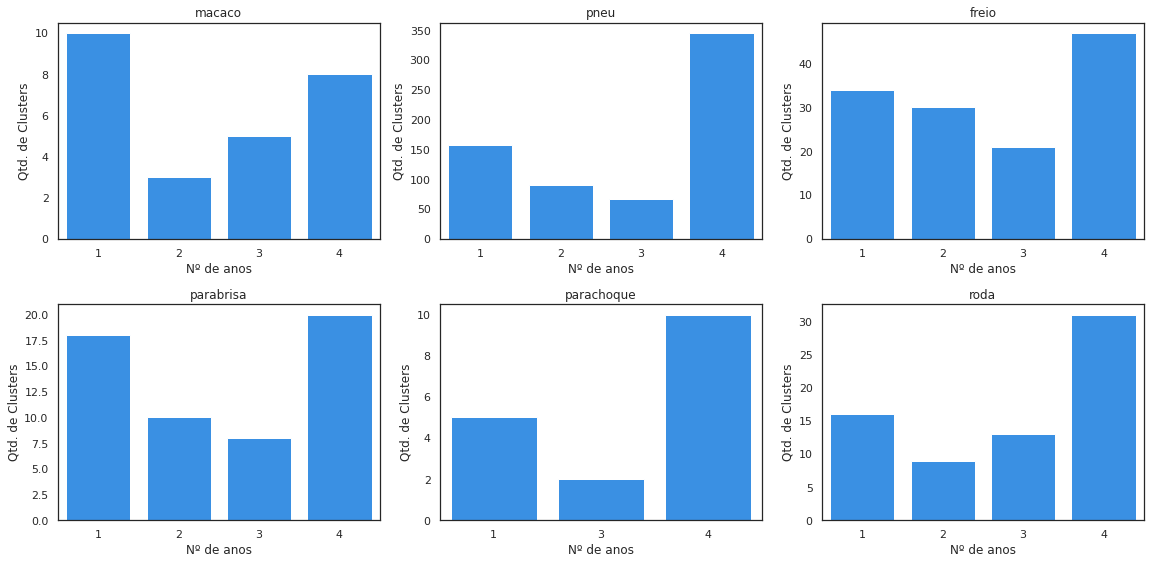

In [363]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, pecas_automotivos):
    items_termo = pecas_years[pecas_years.first_token == termo]
    qtd_clusters = items_termo.drop_duplicates(['cluster', 'dsc_unidade_medida']).groupby("years").apply(lambda clusters: len(clusters))
    sns.barplot(x=qtd_clusters.index, y=qtd_clusters.values, ax=ax, color='dodgerblue')
    ax.set(xlabel="Nº de anos", ylabel="Qtd. de Clusters", title=termo)
fig.tight_layout()
plt.show()

### Quantidade de grupos por ano

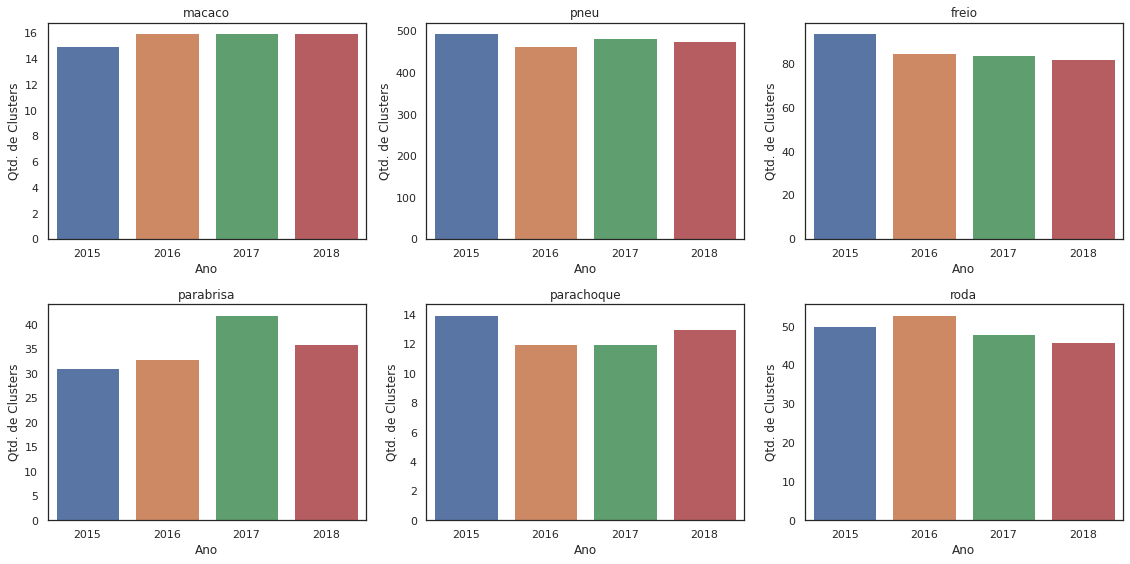

In [61]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, pecas_automotivos):
    items_termo = items[items.first_token == termo]
    qtd_clusters = items_termo.drop_duplicates(['cluster', 'dsc_unidade_medida', 'ano']).groupby("ano").apply(lambda clusters: len(clusters))
    sns.barplot(x=qtd_clusters.index, y=qtd_clusters.values, ax=ax)
    ax.set(xlabel="Ano", ylabel="Qtd. de Clusters", title=termo)
fig.tight_layout()
plt.show()

# Variações de preços

## Combustíveis

### Quantidade de itens nos grupos

Clusters de gasolina; | Mínimo: 1 itens | Máximo: 563 itens 
Clusters de alcool; | Mínimo: 1 itens | Máximo: 326 itens 
Clusters de querosene; | Mínimo: 1 itens | Máximo: 37 itens 
Clusters de oleo; | Mínimo: 1 itens | Máximo: 407 itens 
Clusters de etanol; | Mínimo: 1 itens | Máximo: 145 itens 
Clusters de diesel; | Mínimo: 1 itens | Máximo: 126 itens 


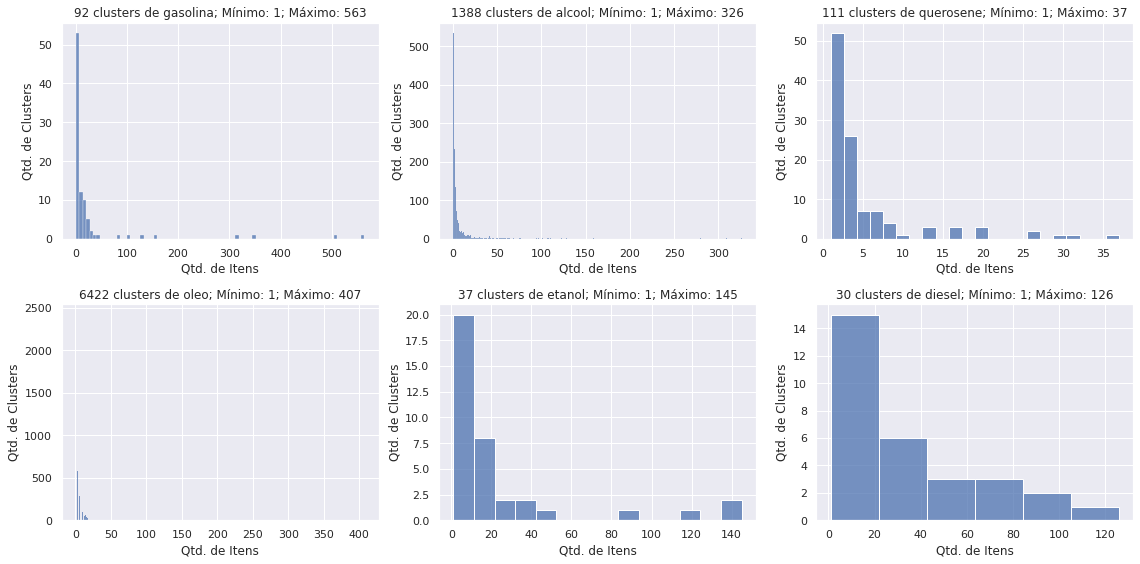

In [178]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, combustiveis):
    items_termo = items[items.first_token == termo]
    qtd_itens = items_termo.groupby(["cluster", "dsc_unidade_medida", "ano"]).size()
    print("Clusters de {}; | Mínimo: {} itens | Máximo: {} itens ".format(termo, min(qtd_itens), max(qtd_itens)))
    sns.histplot(x=qtd_itens, ax=ax)
    ax.set(xlabel="Qtd. de Itens", ylabel="Qtd. de Clusters", title="{} clusters de {}; Mínimo: {}; Máximo: {}".format(len(qtd_itens),termo, min(qtd_itens), max(qtd_itens)))
fig.tight_layout()
plt.show()    

### Variações de preço dos grupos

/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

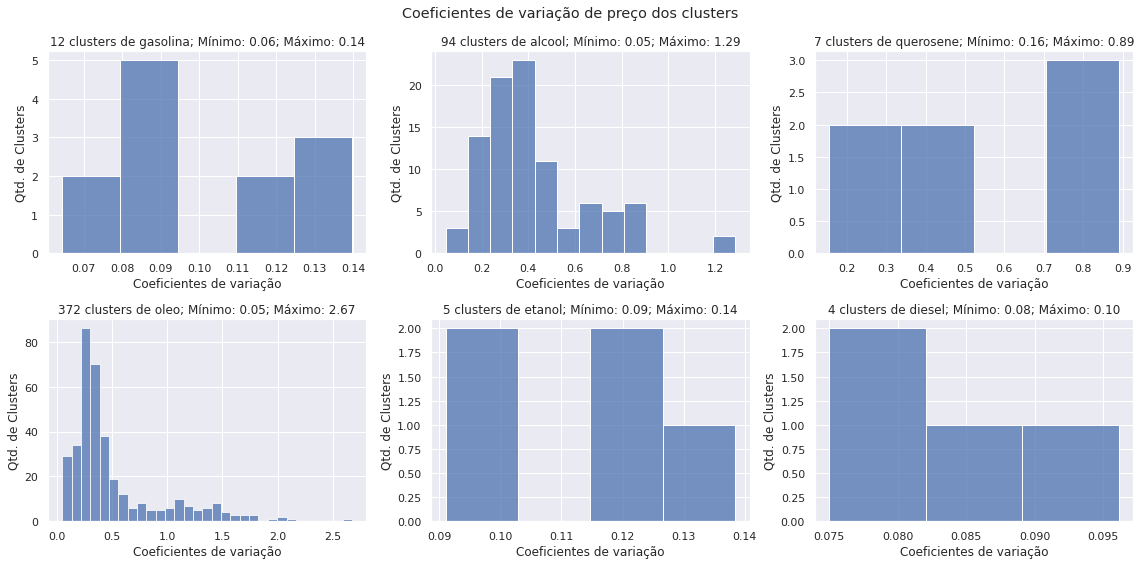

In [190]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, combustiveis):
    clusters_termo = prices[(prices.first_token == termo) & (prices.n_items >= 20)]
    cv = clusters_termo["std"] / clusters_termo["mean"]
    clusters_termo['cv'] = cv
    sns.histplot(data = clusters_termo, x='cv', ax=ax, multiple="dodge")
    ax.set(xlabel="Coeficientes de variação", ylabel="Qtd. de Clusters", title="{} clusters de {}; Mínimo: {:.2f}; Máximo: {:.2f}".format(len(clusters_termo),termo, min(cv), max(cv)))
fig.suptitle("Coeficientes de variação de preço dos clusters")
fig.tight_layout()
plt.show()

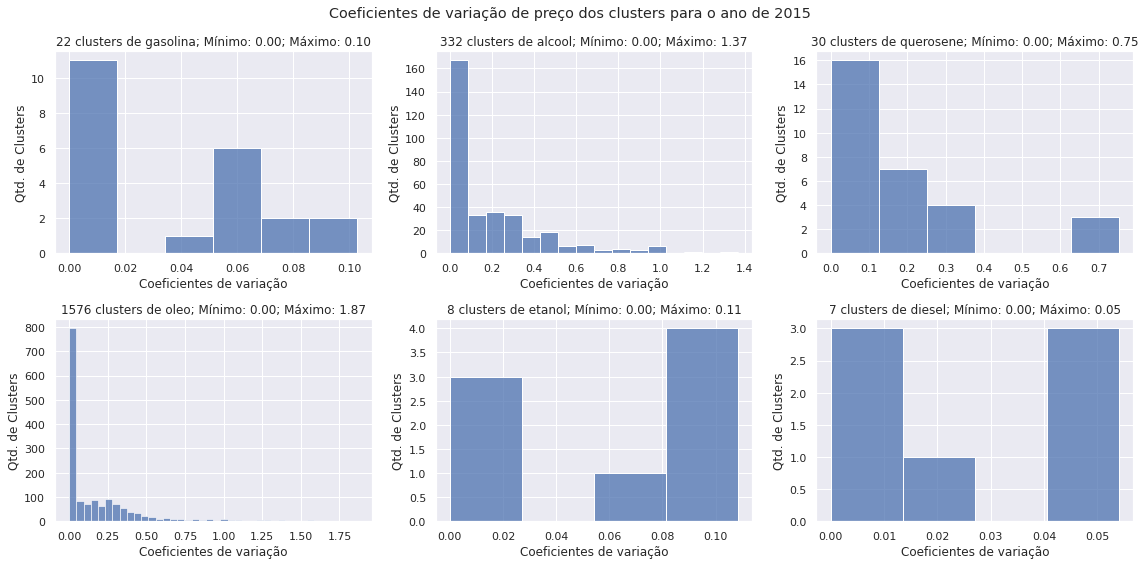

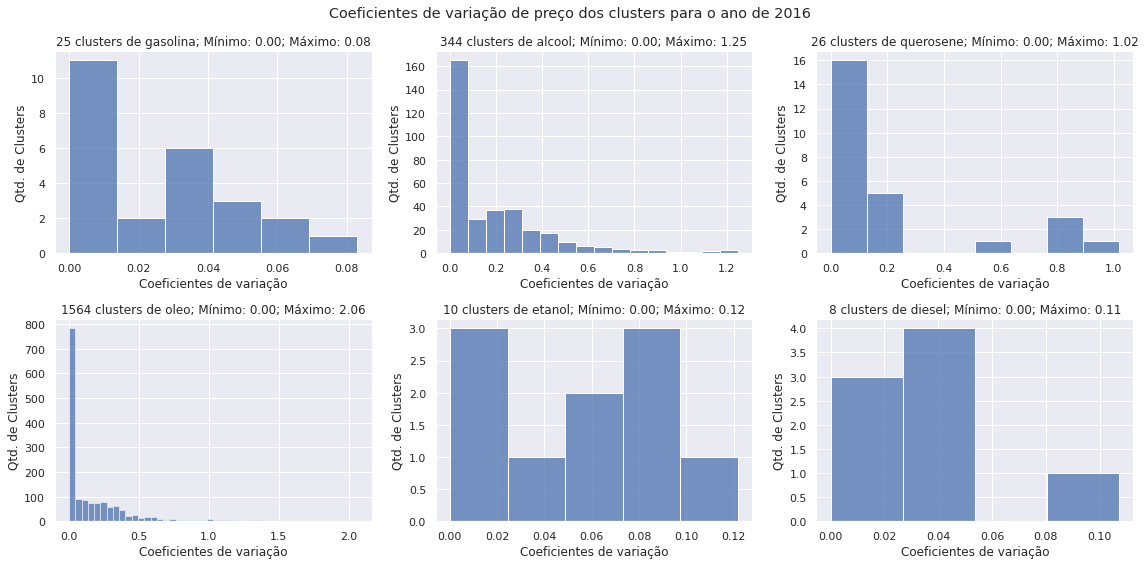

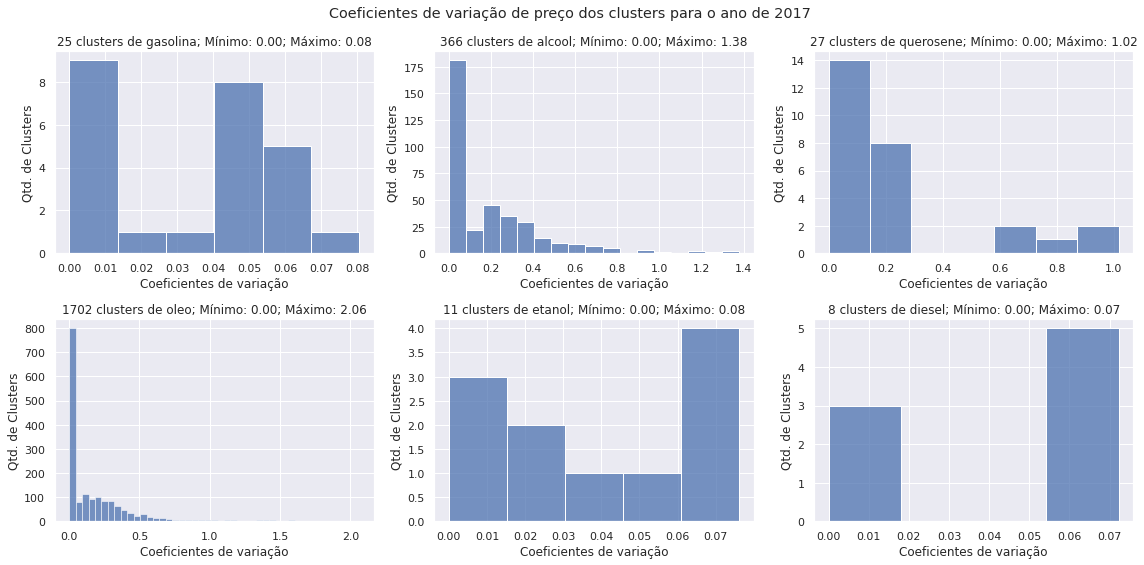

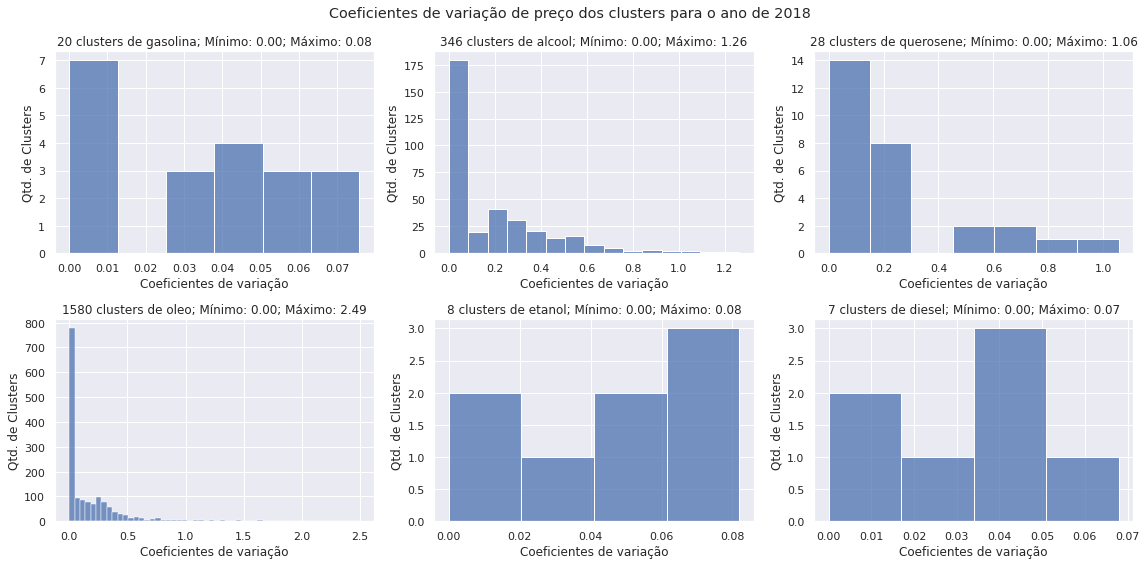

In [553]:
for ano in np.sort(prices.ano.unique()):
    fig, axs = plt.subplots(2, 3, figsize=(16,8))
    for ax, termo in zip(axs.flat, combustiveis):
        clusters_termo = prices[(prices.first_token == termo) & (prices.ano == ano)]
#         unidade = "litro"
#         clusters_termo = clusters_termo[clusters_termo.dsc_unidade_medida == unidade]
        cv = clusters_termo["std"] / clusters_termo["mean"]
        sns.histplot(x=cv, ax=ax)
        ax.set(xlabel="Coeficientes de variação", ylabel="Qtd. de Clusters", title="{} clusters de {}; Mínimo: {:.2f}; Máximo: {:.2f}".format(len(clusters_termo),termo, min(cv), max(cv)))
    fig.suptitle("Coeficientes de variação de preço dos clusters para o ano de {}".format(ano))
    fig.tight_layout()
    plt.show()

## Hospitais e medicamentos

### Quantidade de itens nos grupos

Clusters de luva; | Mínimo: 1 itens | Máximo: 1844 itens 
Clusters de mascara; | Mínimo: 1 itens | Máximo: 350 itens 
Clusters de acido; | Mínimo: 1 itens | Máximo: 189 itens 
Clusters de sabao; | Mínimo: 1 itens | Máximo: 149 itens 
Clusters de sabonete; | Mínimo: 1 itens | Máximo: 188 itens 
Clusters de algodao; | Mínimo: 1 itens | Máximo: 105 itens 


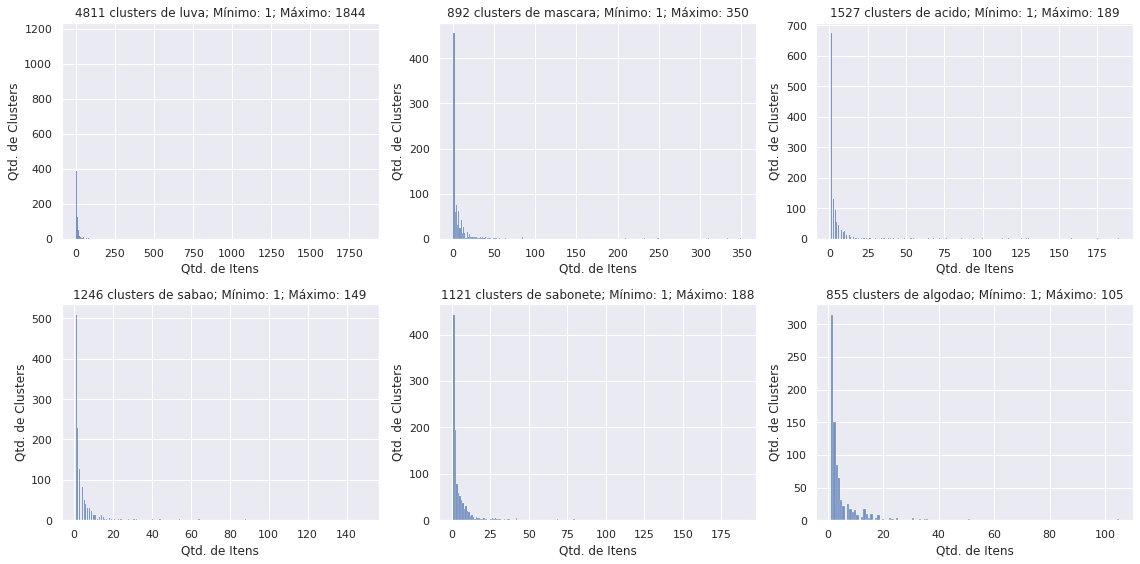

In [450]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, hospitais_med):
    items_termo = items[items.first_token == termo]
    qtd_itens = items_termo.groupby(["cluster", "dsc_unidade_medida", "ano"]).size()
    print("Clusters de {}; | Mínimo: {} itens | Máximo: {} itens ".format(termo, min(qtd_itens), max(qtd_itens)))
    sns.histplot(x=qtd_itens, ax=ax)
    ax.set(xlabel="Qtd. de Itens", ylabel="Qtd. de Clusters", title="{} clusters de {}; Mínimo: {}; Máximo: {}".format(len(qtd_itens),termo, min(qtd_itens), max(qtd_itens)))
fig.tight_layout()
plt.show()    

### Variação de preço dos grupos

/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

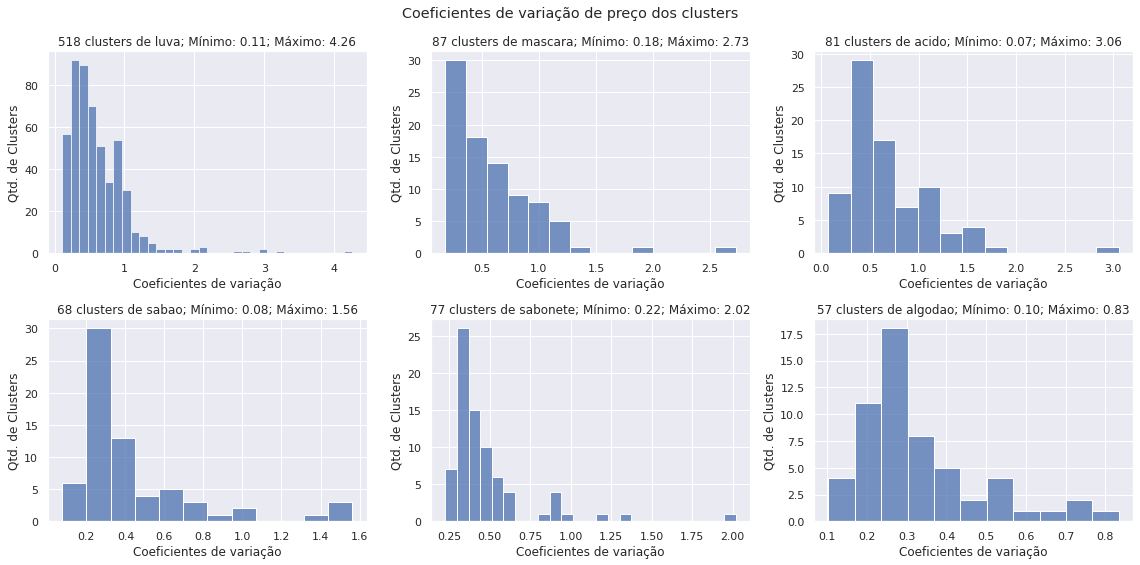

In [191]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, hospitais_med):
    clusters_termo = prices[(prices.first_token == termo) & (prices.n_items >= 20)]
    cv = clusters_termo["std"] / clusters_termo["mean"]
    clusters_termo['cv'] = cv
    sns.histplot(data = clusters_termo, x='cv', ax=ax, multiple="dodge")
    ax.set(xlabel="Coeficientes de variação", ylabel="Qtd. de Clusters", title="{} clusters de {}; Mínimo: {:.2f}; Máximo: {:.2f}".format(len(clusters_termo),termo, min(cv), max(cv)))
fig.suptitle("Coeficientes de variação de preço dos clusters")
fig.tight_layout()
plt.show()

## Peças e serviços automotivos

### Quantidade de itens nos grupos

Clusters de macaco; | Mínimo: 1 itens | Máximo: 42 itens 
Clusters de pneu; | Mínimo: 1 itens | Máximo: 3186 itens 
Clusters de freio; | Mínimo: 1 itens | Máximo: 135 itens 
Clusters de parabrisa; | Mínimo: 1 itens | Máximo: 122 itens 
Clusters de parachoque; | Mínimo: 1 itens | Máximo: 50 itens 
Clusters de roda; | Mínimo: 1 itens | Máximo: 62 itens 


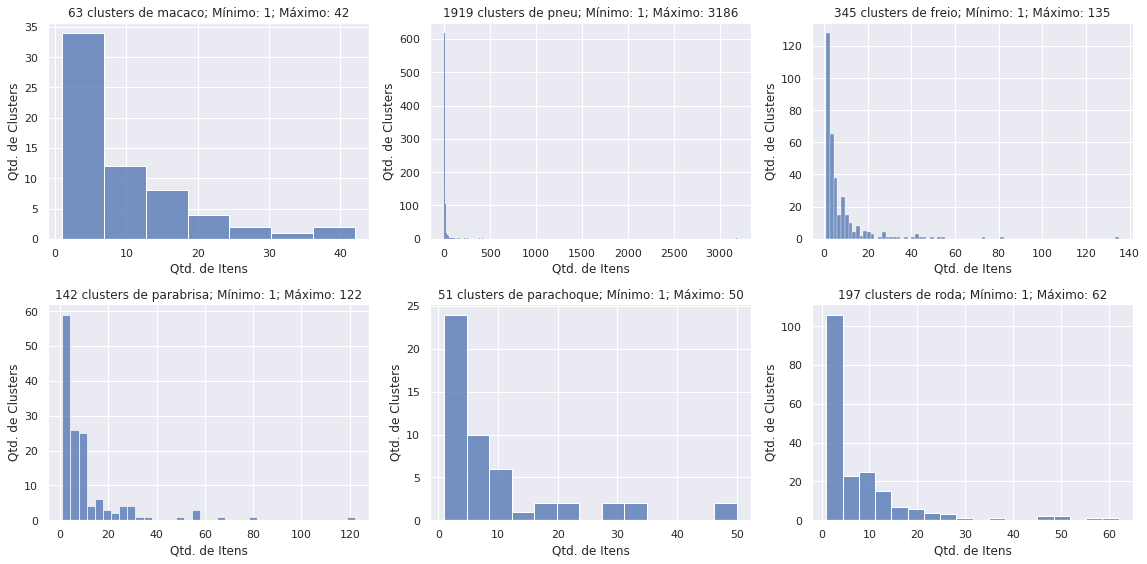

In [556]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, pecas_automotivos):
    items_termo = items[items.first_token == termo]
    qtd_itens = items_termo.groupby(["cluster", "dsc_unidade_medida", "ano"]).size()
    print("Clusters de {}; | Mínimo: {} itens | Máximo: {} itens ".format(termo, min(qtd_itens), max(qtd_itens)))
    sns.histplot(x=qtd_itens, ax=ax)
    ax.set(xlabel="Qtd. de Itens", ylabel="Qtd. de Clusters", title="{} clusters de {}; Mínimo: {}; Máximo: {}".format(len(qtd_itens),termo, min(qtd_itens), max(qtd_itens)))
fig.tight_layout()
plt.show()    

### Variação de preço dos grupos

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(16,8))
for ax, termo in zip(axs.flat, pecas_automotivos):
    clusters_termo = prices[(prices.first_token == termo) & (prices.n_items >= 20)]
    cv = clusters_termo["std"] / clusters_termo["mean"]
    clusters_termo['cv'] = cv
    sns.histplot(data = clusters_termo, x='cv', ax=ax, multiple="dodge")
    ax.set(xlabel="Coeficientes de variação", ylabel="Qtd. de Clusters", title="{} clusters de {}; Mínimo: {:.2f}; Máximo: {:.2f}".format(len(clusters_termo),termo, min(cv), max(cv)))
fig.suptitle("Coeficientes de variação de preço dos clusters")
fig.tight_layout()
plt.show()

/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/dados01/workspace/ufmg.f01dcc/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste